# **MLP - Boston House Prices Dataset**

## [Step 01] 라이브러리 로딩

In [50]:
# Import libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np

In [51]:
# T4(Turing 아키텍처), P100, V100(Volta 아키텍처), A100(Ampere 아키텍처)
!nvidia-smi

Tue Aug  8 16:29:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## [Step 02] 데이터셋 로딩

In [52]:
from sklearn.datasets import fetch_openml
import pandas as pd

X, y = fetch_openml('boston', return_X_y=True, parser='auto', version=1)
df = X
df['PRICE'] = y
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    float64 
 10  PTRATIO  506 non-null    float64 
 11  B        506 non-null    float64 
 12  LSTAT    506 non-null    float64 
 13  PRICE    506 non-null    float64 
dtypes: category(2), float64(12)
memory usage: 49.0 KB


In [54]:
df['CHAS'] = df['CHAS'].astype('float64')
df['RAD'] = df['RAD'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


## [Step 03] 데이터 분석
- EDA(Exploratory Data Analysis, 탐색적 데이터 붅석)
- 데이터를 분석하기 전 그래프나 통계적인 방법으로 자료를 직관적으로 이해하는 과정

### Pandas를 활용한 데이터 출력

> https://pandas.pydata.org/



In [55]:
# Label 데이터 확인
import plotly.express as px

fig = px.histogram(df, x="PRICE")
fig.show()

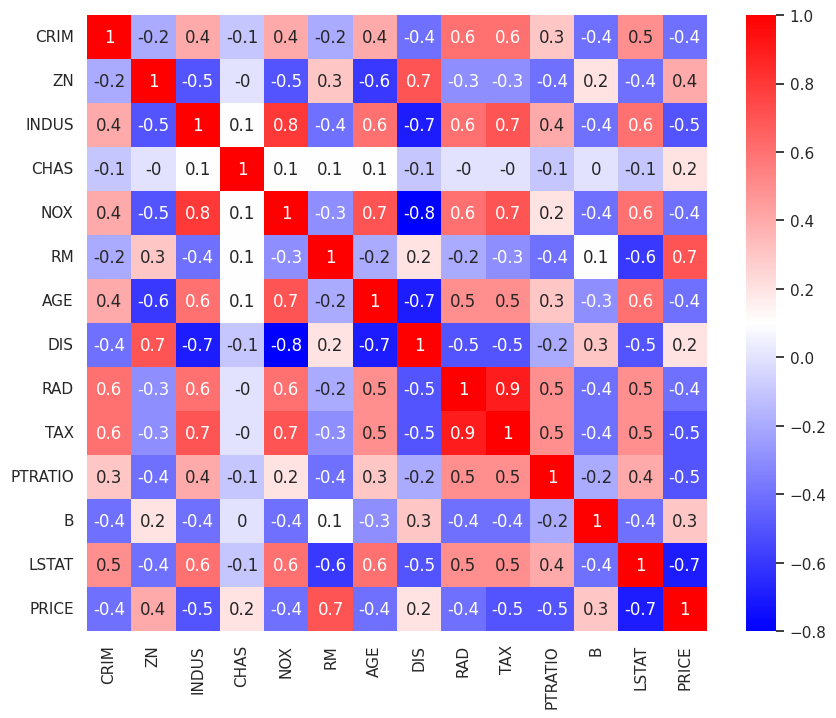

In [56]:
# 상관관계 확인 (RM - 방의 개수, LSTAT - 저소득층 인구)
import matplotlib.pyplot as plt
import seaborn as sns

corr_mat = df.corr().round(1)
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(data=corr_mat, annot=True, cmap='bwr');

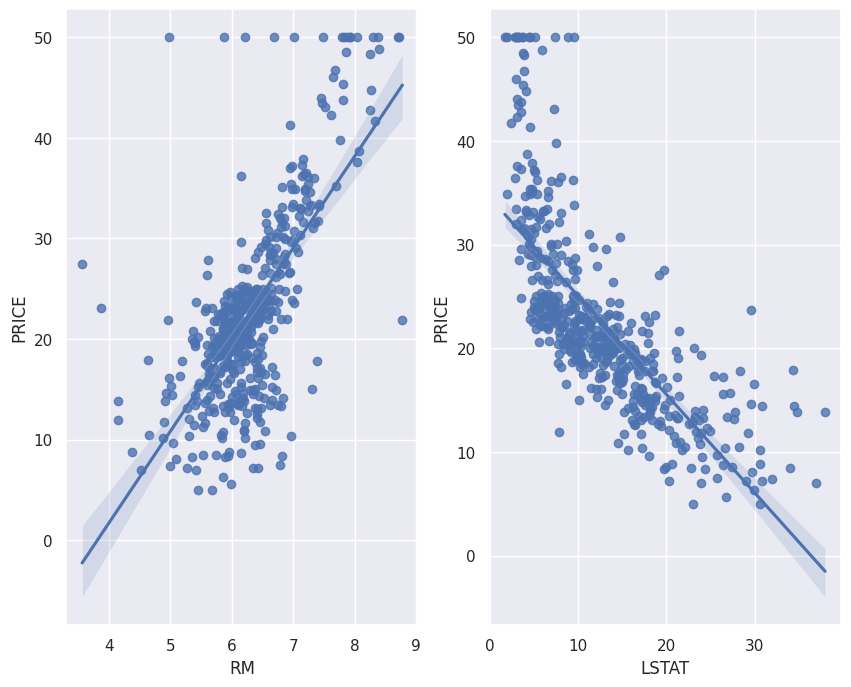

In [57]:
# 주요상관관계 시각화
fig, ax = plt.subplots(1, 2)
sns.regplot(x='RM', y='PRICE', data=df, ax=ax[0])
sns.regplot(x='LSTAT', y='PRICE', data=df, ax=ax[1])
plt.show()

In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#X = df.drop('PRICE', axis=1)
X = df.drop(['PRICE', 'LSTAT'], axis=1)
y = df['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

reg = LinearRegression()
reg.fit(X_train, y_train)

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)
rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print('RMSE of Train Data : ', rmse_tr)
print('RMSE of Test Data : ', rmse_test)

RMSE of Train Data :  5.165137874244864
RMSE of Test Data :  5.295595032597169


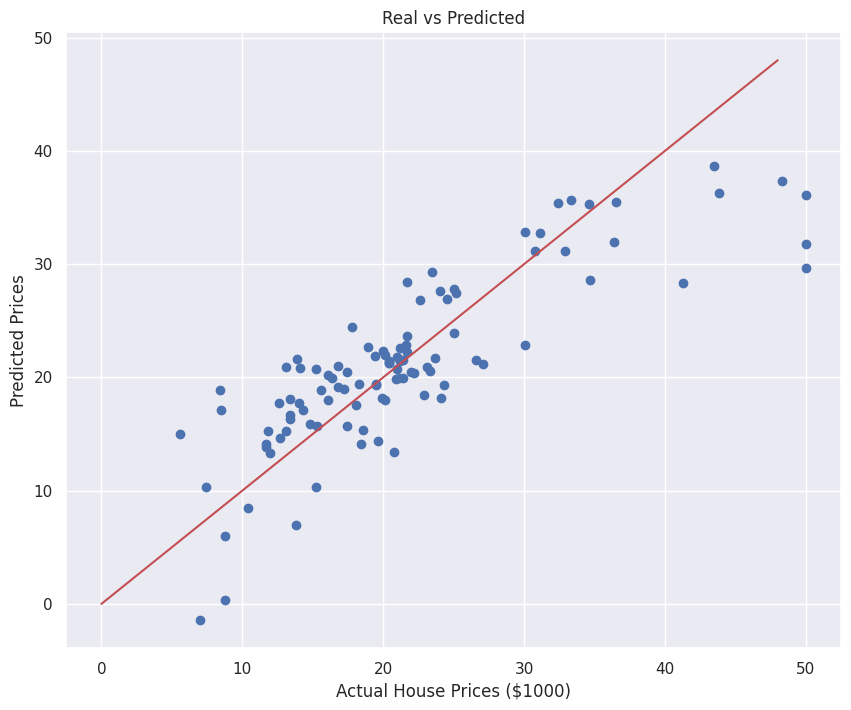

In [ ]:
plt.scatter(y_test, pred_test)
plt.xlabel("Actual House Prices ($1000)")
plt.ylabel("Predicted Prices")
plt.title("Real vs Predicted")
plt.plot([0,48],[0,48],'r')
plt.show()

In [59]:
# 데이터 요약 출력
# 백분위수(k-th percentile) - 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [60]:
df.describe(percentiles=[0.01, 0.05, 0.99])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
1%,0.013610,0.000000,1.253500,0.000000,0.398000,4.524450,6.610000,1.206540,1.000000,188.000000,13.000000,6.730000,2.883000,7.010000
5%,0.027910,0.000000,2.180000,0.000000,0.409250,5.314000,17.725000,1.461975,2.000000,222.000000,14.700000,84.590000,3.707500,10.200000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
99%,41.370330,90.000000,25.650000,1.000000,0.871000,8.335000,100.000000,9.222770,24.000000,666.000000,21.200000,396.900000,33.918500,50.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


### Seaborn을 활용한 데이터 가시화


> https://seaborn.pydata.org/



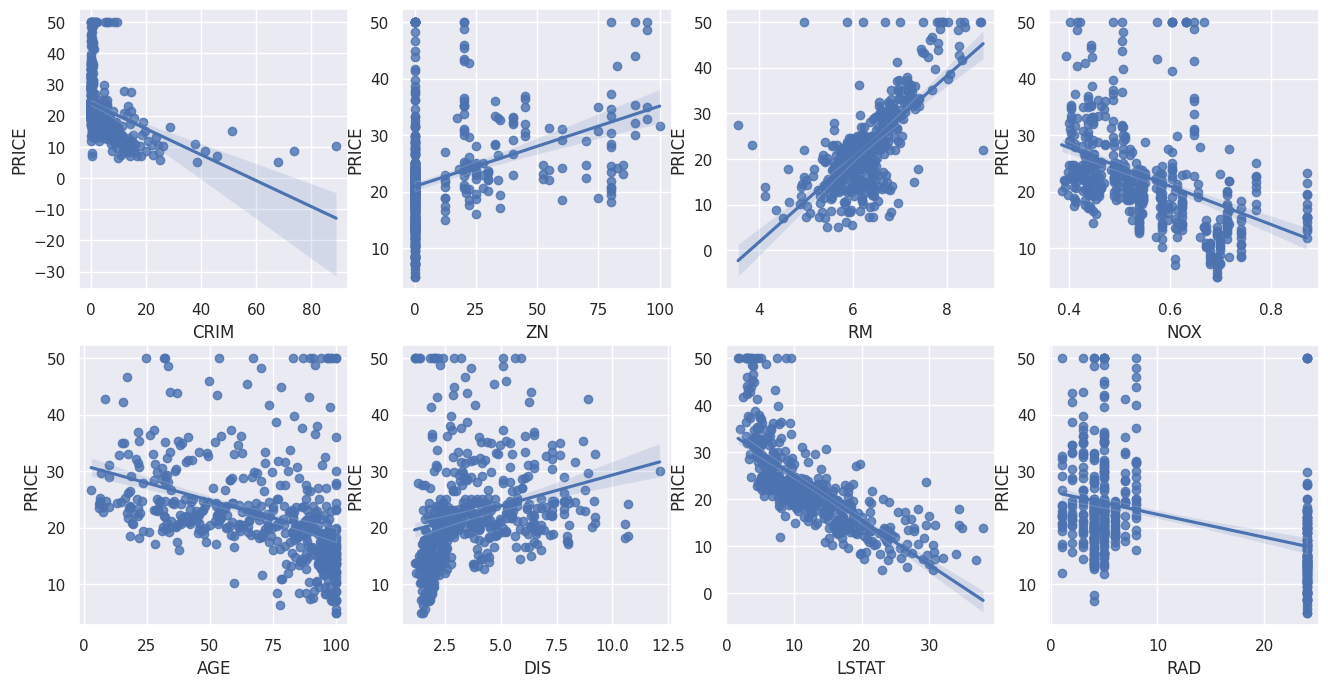

In [62]:
import seaborn as sns

# 2x4 subplot 이용. axs는 4x2
fig, axes = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
features = ['CRIM','ZN','RM','NOX','AGE','DIS','LSTAT','RAD']

for i, feature in enumerate(features):
    row = int(i/4)
    col = i%4

    # Plot data and a linear regression model fit
    sns.regplot(x=feature, y='PRICE', data=df, ax=axes[row][col])

## [Step 04] 데이터 클래스 생성

In [63]:
# 데이터프레임을 넘파이 배열로 만들기
X = df.drop('PRICE', axis=1).to_numpy()
Y = df['PRICE'].to_numpy().reshape((-1, 1))
print(X.shape)
print(Y.shape)

(506, 13)
(506, 1)


In [64]:
from sklearn.preprocessing import MinMaxScaler

# 데이터 스케일링, sklearn에서 제공하는 MinMaxScaler를 활용, (X-min(X))/(max(X)-min(X))
scaler = MinMaxScaler()

scaler.fit(X)
X = scaler.transform(X)
scaler.fit(Y)
Y = scaler.transform(Y)

In [65]:
# 텐서 데이터 클래스 선언
class TensorData(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [66]:
from sklearn.model_selection import train_test_split

# 데이터 나누기(train and test data)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
print(len(X_train))
print(len(X_test))

354
152


In [67]:
# 학습 데이터, 시험 데이터 배치 형태로 구축하기
train_sets = TensorData(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_sets, batch_size=32, shuffle=True)

test_sets = TensorData(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_sets, batch_size=32, shuffle=False)

## [Step 05] MLP 모델 정의

In [68]:
class MLP(nn.Module):
    def __init__(self):

        # Define the deep neural network and dropout
        super().__init__()
        self.fc1 = nn.Linear(13, 50, bias=True)
        self.fc2 = nn.Linear(50, 30, bias=True)
        self.fc3 = nn.Linear(30, 1, bias=True)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))

        return x

## [Step 06] 네트워크 학습

epoch 1 loss: 0.1165
epoch 2 loss: 0.0251
epoch 3 loss: 0.0201
epoch 4 loss: 0.0630
epoch 5 loss: 0.0020
epoch 6 loss: 0.0187
epoch 7 loss: 0.1120
epoch 8 loss: 0.0169
epoch 9 loss: 0.0168
epoch 10 loss: 0.0205
epoch 11 loss: 0.0039
epoch 12 loss: 0.0047
epoch 13 loss: 0.0823
epoch 14 loss: 0.0001
epoch 15 loss: 0.0046
epoch 16 loss: 0.0384
epoch 17 loss: 0.0228
epoch 18 loss: 0.0134
epoch 19 loss: 0.0208
epoch 20 loss: 0.0021
epoch 21 loss: 0.0652
epoch 22 loss: 0.0017
epoch 23 loss: 0.0072
epoch 24 loss: 0.0151
epoch 25 loss: 0.0001
epoch 26 loss: 0.0448
epoch 27 loss: 0.0069
epoch 28 loss: 0.0054
epoch 29 loss: 0.0004
epoch 30 loss: 0.0063
epoch 31 loss: 0.0010
epoch 32 loss: 0.0012
epoch 33 loss: 0.0009
epoch 34 loss: 0.0018
epoch 35 loss: 0.0004
epoch 36 loss: 0.0071
epoch 37 loss: 0.0131
epoch 38 loss: 0.0257
epoch 39 loss: 0.0000
epoch 40 loss: 0.0010
epoch 41 loss: 0.0005
epoch 42 loss: 0.0064
epoch 43 loss: 0.0339
epoch 44 loss: 0.0216
epoch 45 loss: 0.0235
epoch 46 loss: 0.00

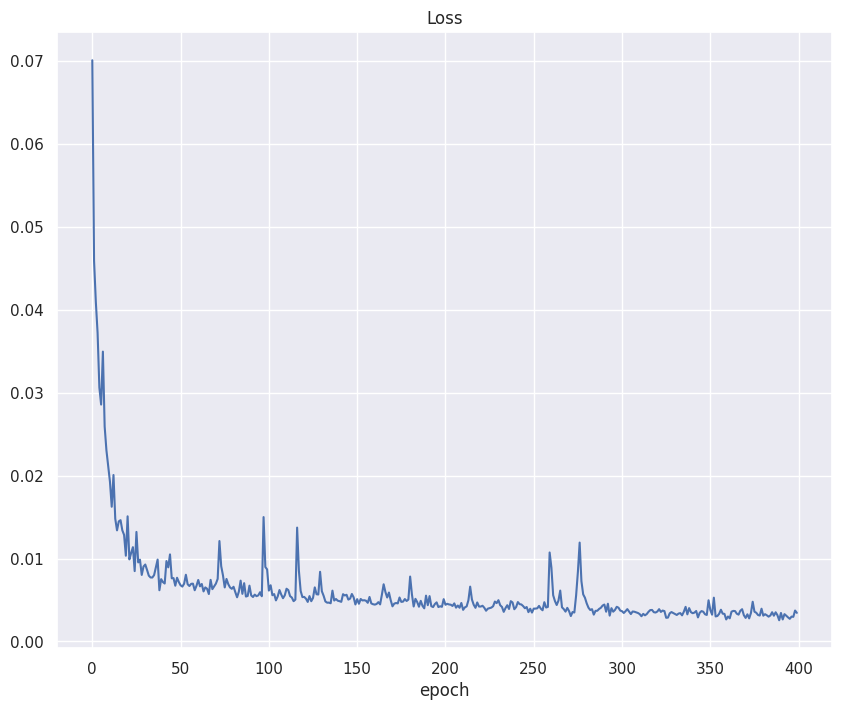

In [69]:
# 모델, 손실함수, 최적화 선언
model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

# 학습 진행
loss_ = []
for epoch in range(400):

    # Loss for each epoch
    running_loss = 0.0

    # Inputs: 32 batch size data
    for i, data in enumerate(train_loader, 0):

        inputs, values = data

        # Optimizer - 매번 초기화 with zero_grad()
        optimizer.zero_grad()

        # 모델 예측값 outputs(32개 - bathch size)
        outputs = model(inputs)

        # Loss function 계산
        loss = criterion(outputs, values)

        # Backpropagation
        loss.backward()

        # model.parameter()의 weight를 업데이트
        optimizer.step()

        running_loss += loss.item()

    # MSE(Mean Squared Error) 계산
    loss_.append(running_loss / len(train_loader))
    print("epoch {} loss: {:.4f}".format(epoch + 1, loss.item()))

plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

## [Step 07] 결과 가시화

[0.8929677]
[0.85555553]


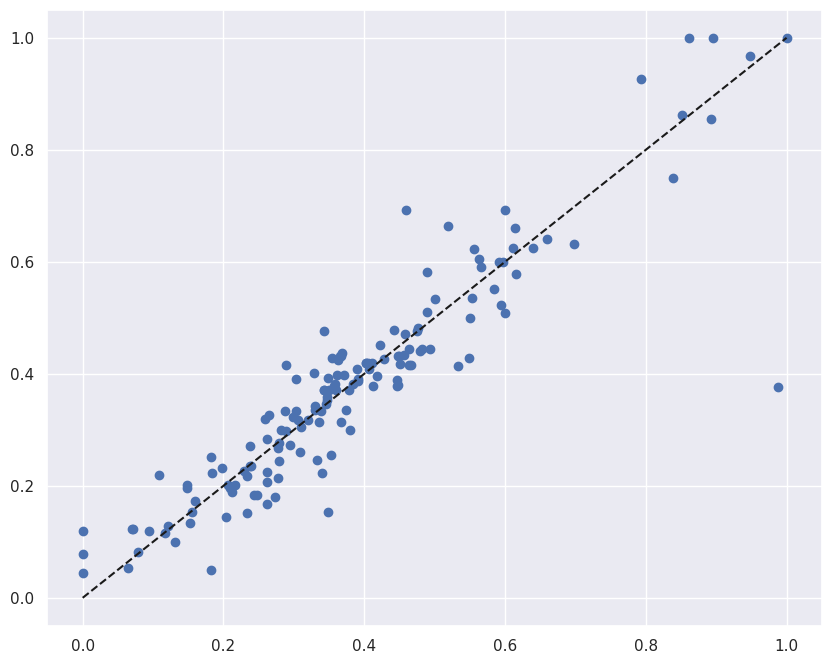

In [70]:
y_pred = []
y_true = []
model.train(False)
for i, data in enumerate(test_loader, 0):
    inputs, values = data
    y_pred.extend(model(inputs).data.numpy())
    y_true.extend(values.numpy())
plt.scatter(y_pred, y_true)
plt.plot([0, 1], [0, 1], '--k')

print(y_pred[5])
print(y_true[5])

In [71]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("MAE:", mean_absolute_error(y_true, y_pred))
print("MSE:", mean_squared_error(y_true, y_pred))
print("R^2:", r2_score(y_true, y_pred))

MAE: 0.047387388
MSE: 0.006008142
R^2: 0.8404109951862239
